In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import accuracy_score
import xgboost as xgb
import seaborn as sns
from torch.optim import lr_scheduler

In [2]:
data = pd.read_csv('data/20230406.csv')

data.columns

/var/folders/z5/9ww3z2cs05sdd9ppqbltwh5w0000gn/T/ipykernel_26484/182237501.py:1: DtypeWarning: Columns (7,9,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/20230406.csv')


Index(['生成时间', '结束时间', '事件名称', '事件类型', '攻击结果', '威胁等级', '源IP', '源端口', '目的IP',
       '目的端口', '设备来源', '发生次数', '规则ID', '响应码', '设备动作', '请求体', '响应体', '研判'],
      dtype='object')

In [3]:
data['响应码'] = data['响应码'].astype(str)
response_code_v = data['响应码'].unique()
print("响应码", response_code_v)

响应码 ['0' '--' '200' '404' '403' '302' '400' '405' '100' '406' '511' '401'
 '501' '502' '301' '500' '206' '505']


In [4]:
data = data[data['研判'] != '无法研判']
label_v = data['研判'].unique()
print("研判", label_v)

研判 ['非攻击' '攻击']


In [5]:
def setup_map (column_name):
    tmp_map = dict()
    tmp = tuple(data[column_name].unique())
    for i in range(len(tmp)):
        tmp_map[tmp[i]] = i
    data[column_name] = data[column_name].map(tmp_map)

setup_map('事件名称')
setup_map('事件类型')
setup_map('攻击结果')
setup_map('设备来源')
setup_map('规则ID')
setup_map('响应码')
setup_map('设备动作')
setup_map('研判')

label_v = data['研判'].unique()
print("研判", label_v)

device_act_v = data['设备动作'].unique()
print("设备动作", device_act_v)


研判 [0 1]
设备动作 [0 1 2]


In [6]:
threat_level_mapping = {'轻微': 0, '一般': 1, '较大': 2, '重大': 3}
data['威胁等级'] = data['威胁等级'].map(threat_level_mapping)

print('威胁等级', data['威胁等级'].sample(5))

威胁等级 30718    1
13248    0
9307     1
27368    1
45481    2
Name: 威胁等级, dtype: int64


In [7]:
event_type_v = data['事件类型'].unique()
attack_res_v = data['攻击结果'].unique()
threaten_lev_v = data['威胁等级'].unique()
response_code_v = data['响应码'].unique()
device_act_v = data['设备动作'].unique()
label_v = data['研判'].unique()

print("事件类型", event_type_v)
print("攻击结果", attack_res_v)
print("威胁等级", threaten_lev_v)
print("响应码", response_code_v)
print("设备动作", device_act_v)
print("研判", label_v)

事件类型 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
攻击结果 [0 1 2]
威胁等级 [2 1 0 3]
响应码 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
设备动作 [0 1 2]
研判 [0 1]


In [8]:
data = data.drop(['生成时间', '结束时间'], axis = 1)
data.drop_duplicates(inplace=True)
data.shape

(47888, 16)

In [9]:
data.isnull().sum()

事件名称    0
事件类型    0
攻击结果    0
威胁等级    0
源IP     0
源端口     0
目的IP    0
目的端口    0
设备来源    0
发生次数    0
规则ID    0
响应码     0
设备动作    0
请求体     0
响应体     0
研判      0
dtype: int64

In [10]:
data['响应体'] = data['响应体'].fillna('')
print(data['响应体'].isnull().sum())

0


In [11]:
def get_var(x):
    cnt = {}
    for c in x:
        if(c != ' '):
            cnt[c] = cnt.get(c, 0) + 1
    if(len(cnt) == 0):
        return 0
    mean_count = sum(cnt.values()) / len(cnt)
    sd = [(count - mean_count)**2 for count in cnt.values()]
    var = sum(sd) / len(cnt)
    return var

def get_len1(x): # rst line length
    if(x == '') :
        return 0
    else:
        return len(x.splitlines()[0])
    
def get_var1(x): # rst line char variance
    if(x == ''):
        return 0
    else:
        return get_var(x.splitlines()[0])
    

http_headers = [
    'Cache-Control', 'Connection', 'Date', 'Pragma', 'Trailer', 'Transfer-Encoding', 'Upgrade', 'Via', 'Warning',
    'Accept', 'Accept-Charset', 'Accept-Encoding', 'Accept-Language', 'Authorization', 'Expect', 'From', 'Host',
    'If-Match', 'If-Modified-Since', 'If-None-Match', 'If-Range', 'If-Unmodified-Since', 'Max-Forwards',
    'Proxy-Authorization', 'Range', 'Referer', 'TE', 'User-Agent',
    'Accept-Ranges', 'Age', 'ETag', 'Location', 'Proxy-Authenticate', 'Retry-After', 'Server', 'Vary', 'WWW-Authenticate',
    'Allow', 'Content-Encoding', 'Content-Language', 'Content-Length', 'Content-Location', 'Content-MD5', 'Content-Range',
    'Content-Type', 'Expires', 'Last-Modified'
]

def get_body(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if not any(header in line for header in http_headers)]
    return ''.join(filtered_lines)

def get_header(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if any(header in line for header in http_headers)]
    return '\n'.join(filtered_lines)

def get_user_agent(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if ('User-Agent' in line)]
    return '\n'.join(filtered_lines)

def get_host(x):
    lines = x.splitlines()[1:]
    filtered_lines = [line for line in lines if ('Host' in line)]
    return '\n'.join(filtered_lines)

def get_var2(x): # body char variance
    if(x == ''):
        return 0
    else:
        return get_var(get_body(x))

def get_var3(x): # header variance
    if(x == ''):
        return 0
    else:
        return get_var(get_header(x))
    
def get_var4(x): # header User-Agent variance
    if(x == ''):
        return 0
    else:
        return get_var(get_user_agent(x))
    
def get_var5(x): # header Host variance
    if(x == ''):
        return 0
    else:
        return get_var(get_host(x))
    
def get_len2(x): # header User-Agent len
    if(x == ''):
        return 0
    else:
        return len(get_user_agent(x))
    
def get_len3(x): # header Host len
    if(x == ''):
        return 0
    else:
        return len(get_host(x))
    
# test get_header
print('header = ', get_header((data[data['研判'] == 1].head(1))['请求体'].values[0]))

# test get_body
print('body = ', get_body((data[data['研判'] == 1].head(1))['请求体'].values[0]))

# test user-agent
print('User-Agent = ', get_user_agent((data[data['研判'] == 1].head(1))['请求体'].values[0]))

# test host
print('Host = ', get_host((data[data['研判'] == 1].head(1))['请求体'].values[0]))


header =  Host: 112.13.167.114:8088
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36
Content-Length: 105
Accept: text/html,application/xhtml xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9
Accept-Language: zh-CN,zh;q=0.9
Connection: close
Content-Type: application/x-www-form-urlencoded; charset=UTF-8
Accept-Encoding: gzip
body =  X-Requested-With: XMLHttpRequest<?xml version="1.0" encoding="UTF-8"?><language>$(echo tbxyn${bwdlq}ccabu^uunzq>webLib/uunzq)</language>
User-Agent =  User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36
Host =  Host: 112.13.167.114:8088


In [12]:
rstlinelen = data['请求体'].apply(lambda x : get_len1(x))
useragentlen = data['请求体'].apply(lambda x : get_len2(x))
hostlen = data['请求体'].apply(lambda x : get_len3(x))
rstlinevar = data['请求体'].apply(lambda x : get_var1(x))
bodyvar = data['请求体'].apply(lambda x : get_var2(x))
headervar = data['请求体'].apply(lambda x : get_var3(x))
useragnetvar = data['请求体'].apply(lambda x : get_var4(x))
hostvar = data['请求体'].apply(lambda x : get_var5(x))
resvar = data['响应体'].apply(lambda x : get_var(x))

In [13]:
data['rstline_len'] = rstlinelen
data['useragent_len'] = useragentlen
data['hostlen'] = hostlen
data['rstlinevar'] = rstlinevar
data['bodyvar'] = bodyvar
data['headervar'] = headervar
data['useragentvar'] = useragentlen
data['hostvar'] = hostvar
data['resvar'] = resvar

data = data.drop(['请求体', '响应体'], axis=1)

print(data.columns)
print(data.shape)

Index(['事件名称', '事件类型', '攻击结果', '威胁等级', '源IP', '源端口', '目的IP', '目的端口', '设备来源',
       '发生次数', '规则ID', '响应码', '设备动作', '研判', 'rstline_len', 'useragent_len',
       'hostlen', 'rstlinevar', 'bodyvar', 'headervar', 'useragentvar',
       'hostvar', 'resvar'],
      dtype='object')
(47888, 23)


In [14]:
def GetNUM(x):
    ret = 1
    for c in x:
        if c == ',':
            ret += 1
    return ret

data['目的端口'] = data['目的端口'].apply(lambda x: GetNUM(str(x)))
data['源端口'] = data['源端口'].apply(lambda x : GetNUM(str(x)))

In [15]:
print(max(data['目的端口']), max(data['源端口']))

100 100


In [16]:
data['源IP'].sample(10)

26295    112.17.44.76(112.17.44.76)ip:112.17.44.76\n中国,...
48553                                      1.117.84.70\n中国
5824                       193.201.186.110\n英国,英格兰,索__敦自治市
31746    112.17.44.75(112.17.44.75)ip:112.17.44.75\n中国,...
33630                              111.1.207.229\n中国,浙江,温州
6614                                   117.180.185.150\n中国
3375                             122.224.146.227\n中国,浙江,杭州
30064                                   36.138.140.208\n中国
36964                              39.184.73.161\n中国,浙江,台州
43913                             117.147.42.114\n中国,浙江,杭州
Name: 源IP, dtype: object

In [17]:
def getPosition(x):
    return x.splitlines()[1]

def getIPasInt(x):
    x = x.splitlines()[0]
    num = [0, 0, 0, 0]
    id = 0
    for c in x:
        if(c <= '9' and c >= '0'):
            num[id] = num[id] * 10 + (int(c) - int('0'))
        else:
            id += 1
        if (id == 4):
            break
    return num[0]*(256**3) + num[1]*(256**2) + num[2]*256 + num[3]

print(getIPasInt('151.80.13.43\n法国,上法兰西大区,鲁贝'))
print(getPosition('151.80.13.43\n法国,上法兰西大区,鲁贝'))

2538605867
法国,上法兰西大区,鲁贝


In [18]:
data['srcIPcity'] = data['源IP'].apply(lambda x : getPosition(x))
data['desIPcity'] = data['目的IP'].apply(lambda x : getPosition(x))

data['srcIP'] = data['源IP'].apply(lambda x : getIPasInt(x))
data['desIP'] = data['目的IP'].apply(lambda x : getIPasInt(x))

data = data.drop(['源IP','目的IP'],axis=1)
data.columns

Index(['事件名称', '事件类型', '攻击结果', '威胁等级', '源端口', '目的端口', '设备来源', '发生次数', '规则ID',
       '响应码', '设备动作', '研判', 'rstline_len', 'useragent_len', 'hostlen',
       'rstlinevar', 'bodyvar', 'headervar', 'useragentvar', 'hostvar',
       'resvar', 'srcIPcity', 'desIPcity', 'srcIP', 'desIP'],
      dtype='object')

In [19]:
data.dtypes

事件名称               int64
事件类型               int64
攻击结果               int64
威胁等级               int64
源端口                int64
目的端口               int64
设备来源               int64
发生次数               int64
规则ID               int64
响应码                int64
设备动作               int64
研判                 int64
rstline_len        int64
useragent_len      int64
hostlen            int64
rstlinevar       float64
bodyvar          float64
headervar        float64
useragentvar       int64
hostvar          float64
resvar           float64
srcIPcity         object
desIPcity         object
srcIP              int64
desIP              int64
dtype: object

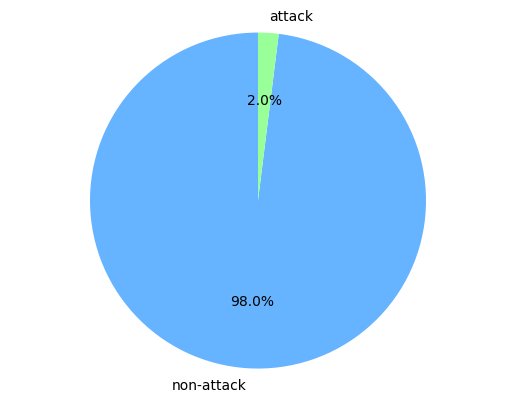

In [20]:
percentage = data['研判'].value_counts(normalize=True) * 100
plt.pie(percentage, labels=['non-attack','attack'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#99ff99'])
plt.axis('equal')
plt.show()

In [21]:
need_one_hot_columns = ['srcIPcity', 'desIPcity', '事件名称','事件类型','攻击结果','响应码','设备来源','规则ID','响应码','设备动作']
data_encoded = pd.get_dummies(data, columns=need_one_hot_columns)

In [22]:
x = data_encoded.drop('研判', axis=1)
y = data_encoded['研判']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
kernal_evals = dict()
def evaluate_classification(model, name, X_train, X_test, y_train, y_test):
    train_accuracy = metrics.accuracy_score(y_train, model.predict(X_train))
    test_accuracy = metrics.accuracy_score(y_test, model.predict(X_test))
    
    train_precision = metrics.precision_score(y_train, model.predict(X_train))
    test_precision = metrics.precision_score(y_test, model.predict(X_test))
    
    train_recall = metrics.recall_score(y_train, model.predict(X_train))
    test_recall = metrics.recall_score(y_test, model.predict(X_test))
    
    kernal_evals[str(name)] = [train_accuracy, test_accuracy, train_precision, test_precision, train_recall, test_recall]
    print("Training Accuracy " + str(name) + " {}  Test Accuracy ".format(train_accuracy*100) + str(name) + " {}".format(test_accuracy*100))
    print("Training Precesion " + str(name) + " {}  Test Precesion ".format(train_precision*100) + str(name) + " {}".format(test_precision*100))
    print("Training Recall " + str(name) + " {}  Test Recall ".format(train_recall*100) + str(name) + " {}".format(test_recall*100))
    
    actual = y_test
    predicted = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['non-attack', 'attack'])

    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    cm_display.plot(ax=ax)

Training Accuracy DecisionTreeClassifier 100.0  Test Accuracy DecisionTreeClassifier 99.43620797661306
Training Precesion DecisionTreeClassifier 100.0  Test Precesion DecisionTreeClassifier 85.77777777777777
Training Recall DecisionTreeClassifier 100.0  Test Recall DecisionTreeClassifier 89.76744186046511


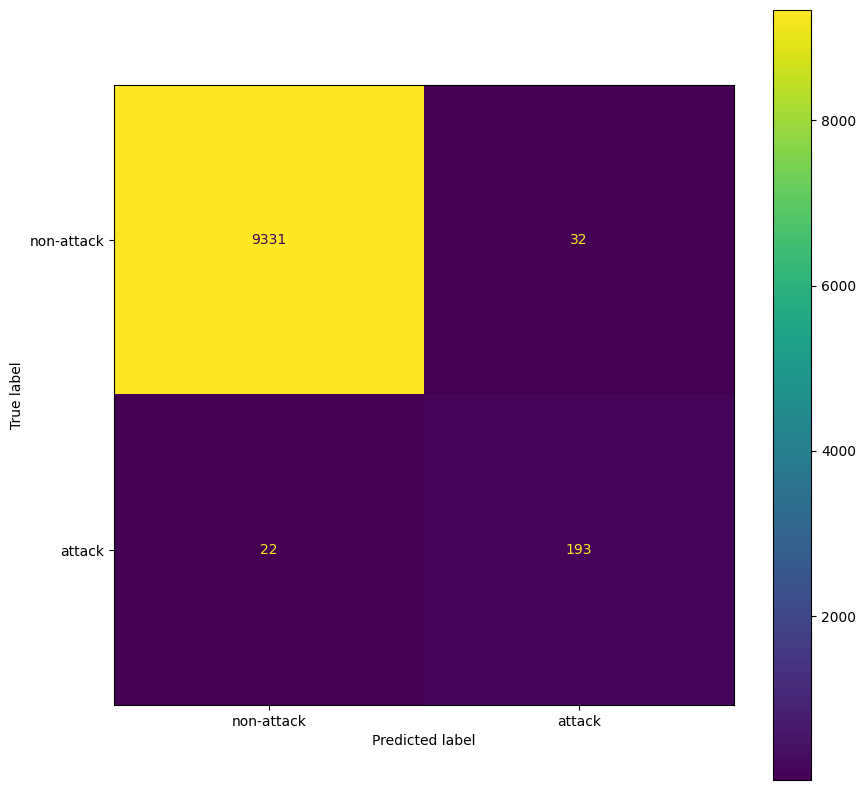

In [24]:
dt = DecisionTreeClassifier(max_depth=6).fit(x_train, y_train)
tdt = DecisionTreeClassifier().fit(x_train, y_train)
evaluate_classification(tdt, "DecisionTreeClassifier", x_train, x_test, y_train, y_test)